In [1]:
# import packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load and preprocess the MNIST dataset

# Define an array transformation that transforms the images to tensor format 
# and normalizes the pixel values to the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the training and test datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, 
    download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, 
    download=True, transform=transform)

# Split the training dataset into a training set and a validation set
train_set, val_set = random_split(train_dataset, [50000, 10000])

# Create data loaders for the training, validation, and test sets
# A DataLoader in PyTorch is an object that simplifies and automates
# batching, shuffling, and loading data for model training and evaluation. 
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [3]:
# Define CNN architecture

class CNN(nn.Module):
    """
    A Convolutional Neural Network (CNN) for classifying MNIST images.
    
    The network consists of a feature extraction architecture and a 
    classification architecture. The feature-extraction architecture includes
    two convolutional layers. Each of the convolutional layers is followed by 
    a sigmoid activation and a max pooling layer. The classification 
    architecture includes two fully connected layers for classification.

    Attributes:
    conv1 : torch.nn.Conv2d
        The first convolutional layer
    conv2 : torch.nn.Conv2d
        The second convolutional layer
    activation : torch.nn activation function
        Activation function used for input and hidden layers
    pool : torch.nn.MaxPool2d
        The pooling layer
    fc1 : torch.nn.Linear
        The first fully connected layer
    fc2 : torch.nn.Linear
        The second fully connected layer

    Methods:
    __init__(self): 
        This function creates an instance of this class.
    forward(self, x):
        Performs a forward pass for an input x.
    """

    def __init__(self):
        """
        Initialize the CNN model by defining its layers.
        """
        # Create an instance of the parent class `nn.Module`
        super(CNN, self).__init__()

        # `self.name = object` creates an attribute with the name `name` for 
        # our the newly created instance of our class, and it assigns that
        # attribute the value `object`. Example: For your first homework, you
        # could have create a class `TicTacToe`. Adding the line 
        # `self.is_game_over = False` to the instance-initialization function
        # of that class would ensure that everytime a new game of TicTacToe is 
        # initialized, it would have an attribute `is_game_over` and initially
        # the value of that attribute would be `False`. 
        # Here, we use the class-attribute syntax to create layers for our CNN.
        
        # Define the first convolutional layer. It uses a 8 filters of size 
        # 3-by-3 to turn a 1-channel image into an 8-channel image.         
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)

        # The MNIST images are grayscale images. Therefore, the input data for
        # out CNN has only one channel. Color images typically come with three
        # channels: a red channel, a green channel, and a blue channel. 
        # Throughout the feature extraction, the number of channels typically 
        # changes quite drastically. The channels of the transformed features
        # typically do not correspond to colors anymore. Instead, different
        # channels of the transformed image contain different information about
        # the original image. For example, a channel created by applying an
        # edge-detection filter would have information about the locations of 
        # sharp edges. A channel created by applying a blur filter would have
        # information about the coarse-grained distribution of light and dark
        # patches.
        
        # Define the second convolutional layer. It uses 16 filters of size 
        # 3-by-3 to turn a 8-channel image into an 16-channel image.
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        # Define the activation function
        self.activation = nn.Sigmoid()
        # Define a pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        # Define a fully connected layer hidden with 128 nodes
        # Inputs are num_channels in previous layer x image height x image width
        self.fc1 = nn.Linear(16 * 8 * 8, 128)
        # Define the output layer with 10 nodes
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        """
        Define the forward pass of the CNN.

        Parameters:
        x : torch.Tensor
            The input tensor containing the image batch.

        Returns:
        torch.Tensor
            The output tensor containing the class scores for each image.
        """
        # Pass the input through the first convolutional layer, then apply activation
        x = self.activation(self.conv1(x))
        # Pass the input through the first pooling layer
        x = self.pool(x)
        # Pass the input through the second convolutional layer, then apply activation
        x = self.activation(self.conv2(x))
        # Pass the input through the second pooling layer
        x = self.pool(x)     
        # Change the shape of x into a 1d array
        x = x.view(-1, 16 * 8 * 8)
        # Pass the input through the full connected hidden layer, then apply activation
        x = self.activation(self.fc1(x))
        # Pass the input through the last layer
        x = self.fc2(x)
        return x

In [4]:
# Define training pipeline including validation after each epoch

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Train the CNN model.

    Parameters:
    model : torch.nn.Module
        The CNN model to be trained.
    train_loader : torch.utils.data.DataLoader
        The data loader for the training set.
    val_loader : torch.utils.data.DataLoader
        The data loader for the validation set.
    criterion : torch.nn.modules.loss._Loss
        The loss function to be used.
    optimizer : torch.optim.Optimizer
        The optimizer to be used.
    epochs : int
        The number of epochs for training.

    Returns:
    tuple
        A tuple containing lists of training loss, validation loss, training accuracy, and validation accuracy.
    """
    # Initialize lists to store training and validation loss
    train_loss, val_loss = [], []
    # Initialize lists to store training and validation and accuracy
    train_acc, val_acc = [], []

    # Loop over the number of epochs
    for epoch in range(epochs):
        # Set the model to training mode
        model.train()  
        # Initialize the running loss for the epoch
        running_loss = 0.0  
        # Initialize counters for correct predictions and total samples
        correct, total = 0, 0  

        # Learning algorithm is SGD with minibatch. Iterating over the dataload
        # returns images and labels in batches.
        
        # Iterate over batches of training data
        for images, labels in train_loader:
            # Zero the gradients to prevent accumulation from previous iterations
            optimizer.zero_grad()  
            # Perform a forward pass through the model to get predictions
            outputs = model(images)  
            # Compute the loss between predictions and true labels
            loss = criterion(outputs, labels)  
            # Perform a backward pass to compute gradients via backpropagation
            loss.backward()  
            # Update model parameters based on the computed gradients
            optimizer.step()  

            # Add up the loss
            running_loss += loss.item()  
            # Get the predicted class with the highest score
            _, predicted = torch.max(outputs.data, 1)  
            # Update the total number of samples
            total += labels.size(0)  
            # Update the number of correct predictions
            correct += (predicted == labels).sum().item()  

        # Compute and store the average training loss for the epoch
        train_loss.append(running_loss / len(train_loader))  
        # Compute and store the training accuracy for the epoch
        train_acc.append(100 * correct / total)  

        # Set the model to evaluation mode
        model.eval()  
        # Initialize the running loss for validation
        val_running_loss = 0.0  
        #  Initialize counters for correct predictions and total samples in validation
        val_correct, val_total = 0, 0  
        
        # Disable gradient calculation for validation to save memory and computation
        with torch.no_grad():
            # Iterate over batches of validation data
            for images, labels in val_loader:
                # Perform a forward pass through the model to get predictions
                outputs = model(images)  
                # Compute the loss between predictions and true labels
                loss = criterion(outputs, labels)  
                # Add up the loss
                val_running_loss += loss.item()  
                # Get the predicted class with the highest score
                _, predicted = torch.max(outputs.data, 1)  
                # Update the total number of samples in validation
                val_total += labels.size(0)  
                # Update the number of correct predictions in validation
                val_correct += (predicted == labels).sum().item()  

        # Compute and store the average validation loss for the epoch
        val_loss.append(val_running_loss / len(val_loader))
        # Compute and store the validation accuracy for the epoch
        val_acc.append(100 * val_correct / val_total)  
        
        # Print the results for the current epoch, including training and validation loss and accuracy
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss / len(train_loader):.4f}, '
              f'Validation Loss: {val_running_loss / len(val_loader):.4f}, '
              f'Train Acc: {100 * correct / total:.2f}%, Val Acc: {100 * val_correct / val_total:.2f}%')
        
    # Return the lists of training and validation loss and accuracy
    return train_loss, val_loss, train_acc, val_acc  

In [5]:
# Build and train a model

# Create model
model = CNN()

# Set loss function
criterion = nn.CrossEntropyLoss()

# Set training algorithm
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer)

Epoch [1/10], Train Loss: 1.4146, Validation Loss: 0.4679, Train Acc: 53.98%, Val Acc: 87.01%
Epoch [2/10], Train Loss: 0.3315, Validation Loss: 0.2723, Train Acc: 90.66%, Val Acc: 91.91%
Epoch [3/10], Train Loss: 0.2129, Validation Loss: 0.1936, Train Acc: 93.82%, Val Acc: 94.58%
Epoch [4/10], Train Loss: 0.1548, Validation Loss: 0.1515, Train Acc: 95.48%, Val Acc: 95.68%
Epoch [5/10], Train Loss: 0.1217, Validation Loss: 0.1325, Train Acc: 96.41%, Val Acc: 96.06%
Epoch [6/10], Train Loss: 0.1011, Validation Loss: 0.1112, Train Acc: 97.00%, Val Acc: 96.70%
Epoch [7/10], Train Loss: 0.0856, Validation Loss: 0.0941, Train Acc: 97.48%, Val Acc: 97.09%
Epoch [8/10], Train Loss: 0.0745, Validation Loss: 0.0835, Train Acc: 97.80%, Val Acc: 97.37%
Epoch [9/10], Train Loss: 0.0669, Validation Loss: 0.0811, Train Acc: 98.01%, Val Acc: 97.56%
Epoch [10/10], Train Loss: 0.0601, Validation Loss: 0.0797, Train Acc: 98.17%, Val Acc: 97.27%


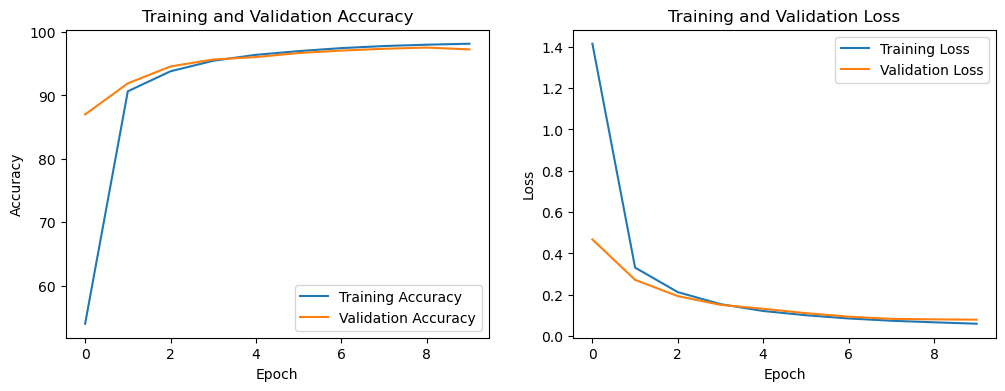

In [6]:
# Plot training & validation accuracy/loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.show()

In [8]:
# Evaluate the model on test set

model.eval()
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 98.05%
